In [1]:
import MGBlurr.blurring as blur
import MGTomo.model as mgmodel
import MGTomo.tomoprojection as mgproj
from MGTomo.utils import mylog
import MGTomo.functions as fcts
from MGTomo.optimize import armijo_linesearch, box_bounds

from MGTomo.gridop import RBox as R, PBox as P

from MGTomo import gridop

import time
import numpy as np
import torch
from torch.linalg import matrix_norm

import matplotlib.pyplot as plt 
from skimage import data
from skimage.transform import resize

In [2]:
N = 1023
max_levels = 5
maxIter = [1,2,16,32,64,123]
kernel_size = 33
sigma = 10

# load image
x_orig = data.camera()
x_orig = resize(x_orig, (N,N), anti_aliasing = False)

x_torch = torch.tensor(x_orig, requires_grad = True)

A = [blur.GaussianBlurOperator(N, kernel_size, sigma)]
b = [A[0](x_torch)]

P_nonzero = []

fine_dim = N
for i in range(1, max_levels+1):
    coarse_dim = blur.reduce_dim(fine_dim)
    A.append(blur.GaussianBlurOperator(coarse_dim, kernel_size, sigma))
    rhs = resize(b[-1].detach().numpy(), (coarse_dim, coarse_dim), anti_aliasing=False)
    b.append(torch.tensor(rhs, requires_grad=True)) #maybe use a different way to define bH
    P_nonzero.append(gridop.compute_nonzero_elements_of_P(coarse_dim))
    fine_dim = coarse_dim

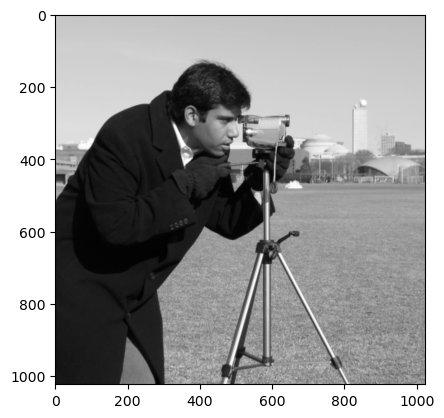

In [3]:
plt.imshow(x_orig, cmap='gray')

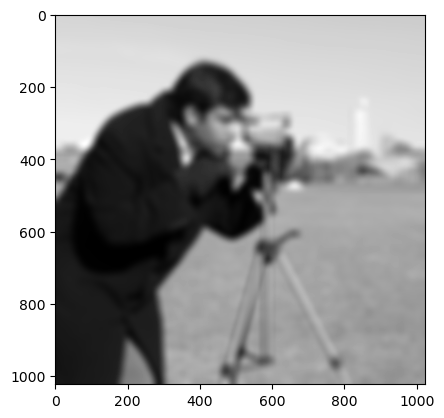

In [4]:
plt.imshow(b[0].detach(), cmap='gray')

In [5]:
fh = lambda x: fcts.kl_distance(x, A[0], b[0])
tau = [0.5 * torch.reciprocal(matrix_norm(bi, ord = 1)) for bi in b]
P_inf = 1

In [6]:
def coarse_condition_v2(y, grad_y, kappa, eta, y_last = None):
    with torch.no_grad():
        gcond = (matrix_norm(R(grad_y)) >= kappa * matrix_norm(grad_y))
        if gcond:
            if y_last is not None:
                y_diff_norm = matrix_norm(y_last - y)
                y_norm = matrix_norm(y)
                return (y_diff_norm >= eta * y_norm)
            return True
        else:
            return False

In [7]:
def MLO_box(fh, y, lh, uh, last_pts: list, l=0, kappa = 0.45, eps = 0.001):
    x = R(y).detach().requires_grad_(True)
    y0 = y.detach().requires_grad_(True)
    fhy0 = fh(y)
    fhy0.backward(retain_graph = True)
    #fhy0.backward()
    grad_fhy0 = y.grad.clone()
    y.grad = None
    
    if coarse_condition_v2(y, grad_fhy0, kappa, eps, last_pts[l]):
    #if coarse_condition_v3(grad_fhy0, kappa, eps):
        print(l, ' : coarse correction activated')
        last_pts[l] = y.clone().detach()
    
        x0 = x.clone().detach().requires_grad_(True)
        fH = lambda x: fcts.kl_distance(x, A[l+1], b[l+1])
        fHx0 = fH(x0)
        fHx0.backward(retain_graph = True)
        grad_fHx0 = x0.grad.clone()
        x0.grad = None

        kappa = R(grad_fhy0) - grad_fHx0
        del grad_fHx0

        with torch.no_grad():
            psi = lambda x: fH(x) + torch.sum(kappa * x)
            lH, uH = box_bounds(y, x, P_inf, lh, uh, P_nonzero[l])

        logvH_new = mylog(x - lH) - mylog(uH - x)
        for i in range(maxIter[l+1]):
            #x.retain_grad()
            val, logvH_new = fcts.BSMART_general(psi, x, logvH_new, tau[l+1], lH, uH)
            x = val.detach().requires_grad_(True)
            del val
            x.grad = None
            
        if l < max_levels-1:
            x, last_pts = MLO_box(psi, x,lH, uH, last_pts, l+1)

        d = P(x-x0)
        z, _ = armijo_linesearch(fh, y0, d)
        y = z.detach().requires_grad_(True)
    else: 
        print(l, ' : coarse correction not activated')

    logvh_new = mylog(y - lh) - mylog(uh - y)
    
    for i in range(maxIter[l]):
        #y.retain_grad()
        yval, logvh_new = fcts.BSMART_general(fh, y, logvh_new, tau[l], lh, uh)
        y = yval.detach().requires_grad_(True)
        del yval
        y.grad = None
    return y, last_pts

In [8]:
w0 = torch.ones(N, N, requires_grad = True)*0.5
lh = torch.zeros_like(w0)
uh = torch.ones_like(w0)

rel_f_err_SL = []
rel_f_err_SL.append((matrix_norm(w0 - x_torch)/matrix_norm(w0)).item())

norm_fval_SL = []
norm_fval_SL.append(torch.tensor(1.))

fhw = fh(w0)
w0.retain_grad()
fhw.backward(retain_graph=True)
Gw0 = matrix_norm(w0.grad)

iteration_times_SL = []
iteration_times_SL.append(0)
overall_start_time_SL = time.time()  # Start overall timing

logv_new = (w0 - lh) / (uh - w0)

norm_grad_SL = []
norm_grad_SL.append(torch.tensor(1.))

for i in range(20):
    iteration_start_time_SL = time.time()  # Start timing for this iteration
    
    val, logv_new = fcts.BSMART_general(fh, w0, logv_new, tau[0], lh, uh)
    
    iteration_end_time_SL = time.time()  # End timing for this iteration
    iteration_time_SL = iteration_end_time_SL - iteration_start_time_SL  # Calculate elapsed time for this iteration
    
    iteration_times_SL.append(iteration_time_SL)
    w0 = val.clone().detach().requires_grad_(True)

    rel_f_err_SL.append((matrix_norm(w0-x_torch)/matrix_norm(w0)).item())
    fval = fh(w0)
    fval.backward(retain_graph=True)
    norm_grad_SL.append((matrix_norm(w0.grad)/Gw0).item())
    norm_fval_SL.append((fval/fhw).item())
    
    print(f"Iteration {i}: {fh(w0)} - Time: {iteration_time_SL:.6f} seconds")

overall_end_time_SL = time.time()  # End overall timing
overall_time_SL = overall_end_time_SL - overall_start_time_SL  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time_SL:.6f} seconds")
cumaltive_times_SL = [sum(iteration_times_SL[:i+1]) for i in range(len(iteration_times_SL))]

Iteration 0: 273678.91637488024 - Time: 6.427991 seconds
Iteration 1: 273485.18187370826 - Time: 6.286275 seconds
Iteration 2: 273291.2900420699 - Time: 6.325368 seconds
Iteration 3: 273097.39291194757 - Time: 6.346831 seconds
Iteration 4: 272903.4155630585 - Time: 6.154928 seconds
Iteration 5: 272709.36790229246 - Time: 6.322340 seconds
Iteration 6: 272515.2385686534 - Time: 6.158370 seconds
Iteration 7: 272321.0430513512 - Time: 6.440648 seconds
Iteration 8: 272126.78466633044 - Time: 6.190345 seconds
Iteration 9: 271932.44095616543 - Time: 6.315281 seconds
Iteration 10: 271738.0248209612 - Time: 6.365483 seconds
Iteration 11: 271543.54199731187 - Time: 6.124434 seconds
Iteration 12: 271348.9806035212 - Time: 6.018506 seconds
Iteration 13: 271154.36768207373 - Time: 6.338510 seconds
Iteration 14: 270959.67278219375 - Time: 6.851342 seconds


In [ ]:
P_inf = 1
a = []
z0 = torch.ones(N, N) * 0.5
z0.requires_grad_(True)
last_pts = [None]*(max_levels+1)

rel_f_err = []
rel_f_err.append((matrix_norm(z0 - x_torch)/matrix_norm(z0)).item())

norm_fval = []
norm_fval.append(torch.tensor(1.))

fhz = fh(z0)

fhz.backward(retain_graph=True)
Gz0 = matrix_norm(z0.grad)
z0.grad = None

norm_grad = []
norm_grad.append(torch.tensor(1.))

iteration_times_ML = []
iteration_times_ML.append(0)
overall_start_time_ML = time.time()

for i in range(10):
    iteration_start_time_ML = time.time()
    
    val, ylast = MLO_box(fh, z0, lh, uh, last_pts)
    iteration_end_time_ML = time.time()
    
    iteration_time_ML = iteration_end_time_ML - iteration_start_time_ML
    iteration_times_ML.append(iteration_time_ML)

    z0 = val.clone().detach().requires_grad_(True)
    rel_f_err.append((matrix_norm(z0-x_torch)/matrix_norm(z0)).item())
    fval = fh(z0)
    norm_fval.append((fval/fhz).item())
    fval.backward(retain_graph=True)
    norm_grad.append((matrix_norm(z0.grad)/Gz0).item())
    z0.grad = None
    print(f"Iteration {i}: {fh(z0)} - Time: {iteration_time_ML:.6f} seconds")

overall_end_time_ML = time.time()  # End overall timing
overall_time_ML = overall_end_time_ML - overall_start_time_ML  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time_ML:.6f} seconds")

cumaltive_times_ML = [sum(iteration_times_ML[:i+1]) for i in range(len(iteration_times_ML))]

0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
3  : coarse correction activated
4  : coarse correction activated
Iteration 0: 153152.67728246824 - Time: 49.598604 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
3  : coarse correction activated
4  : coarse correction activated
Iteration 1: 150433.84451500635 - Time: 50.871935 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
3  : coarse correction activated
4  : coarse correction activated
Iteration 2: 147757.230600239 - Time: 49.745255 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
3  : coarse correction activated
4  : coarse correction activated
Iteration 3: 145122.59923522684 - Time: 45.561568 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
3  : coarse

KeyboardInterrupt: 